## Importing Keras Libraries and Modules


In [0]:
from keras import backend as K
import numpy as np
import time
import cv2
import sys
# Importing matplot library
import matplotlib.pyplot as plt
% matplotlib inline
# Seed the generator
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout,SpatialDropout2D,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

##Importing Cifar10 dataset

In [0]:
# Importing Cifar10 dataset
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

## Ploting each class from cifar10 dataset

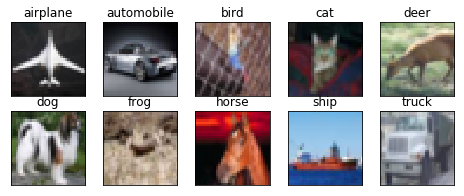

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Function for ploting model history

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Function for accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

##  Function for CutOut

In [0]:
def get_random_eraser(p=0.25, s_l=0.02, s_h=0.5, r_1=0.25, r_2=1/0.25, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

## Converting Class Labels

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Define the model

In [0]:
model = Sequential()

model.add(Conv2D(48, (3, 3), activation='relu', padding ='same', input_shape=(32, 32, 3))) #32
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(48, (3, 3), activation='relu')) #30
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2, 2))) #15


model.add(Conv2D(96, (3, 3), activation='relu', padding ='same')) # 15
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(192, (3, 3), activation='relu')) # 13
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(192, (3, 3), activation='relu')) # 11
model.add(BatchNormalization())
model.add(Dropout(0.25))


#model.add(MaxPooling2D(pool_size=(2, 2))) #5


model.add(Conv2D(192, (3, 3), activation='relu', padding ='same')) #5
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(192, (3, 3), activation='relu')) # 5
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(192, (3, 3), activation='relu')) # 3
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(10, 1, name = 'last_layer'))#1
model.add(GlobalAveragePooling2D())

#model.add(Flatten())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of model
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 32, 32, 48)        1344      
_________________________________________________________________
batch_normalization_95 (Batc (None, 32, 32, 48)        192       
_________________________________________________________________
dropout_95 (Dropout)         (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 30, 30, 48)        20784     
_________________________________________________________________
batch_normalization_96 (Batc (None, 30, 30, 48)        192       
_________________________________________________________________
dropout_96 (Dropout)         (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 15, 48)        0         
__________

## Train the Model

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
391/390 [==============================] - 68s 173ms/step - loss: 1.5771 - acc: 0.4265 - val_loss: 1.5940 - val_acc: 0.4805
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
391/390 [==============================] - 54s 138ms/step - loss: 1.0938 - acc: 0.6075 - val_loss: 1.0578 - val_acc: 0.6306
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
391/390 [==============================] - 54s 138ms/step - loss: 0.8857 - acc: 0.6851 - val_loss: 0.9262 - val_acc: 0.6750
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
391/390 [==============================] - 54s 138ms/step - loss: 0.7636 - acc: 0.7307 - val_loss: 0.7174 - val_acc: 0.7559
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
391/390 [==============================] - 54s 138ms/step - loss: 0.6780 - a

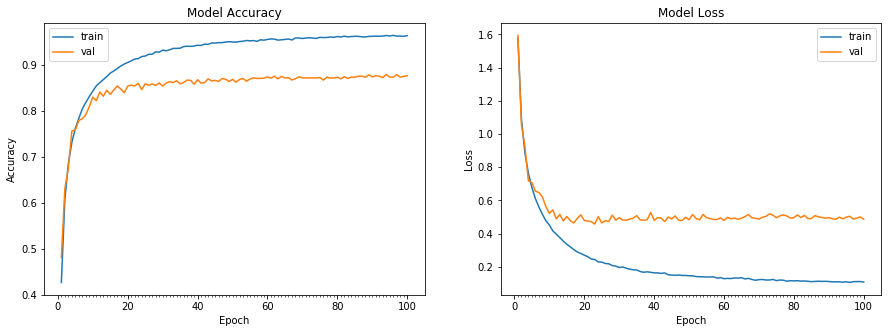

Accuracy on test data is: 87.60


In [0]:
# Image Normalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
# CutOut 
datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1))
start = time.time()
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 steps_per_epoch = train_features.shape[0]/128, epochs = 100, 
                                 validation_data = (test_features, test_labels),callbacks=[LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## Accuracy on test data is: 87.60

In [0]:
y_pred = model.predict_generator(datagen.flow(test_features, test_labels,shuffle=False, batch_size = 128),steps=len(test_features)/128)

y_pred_argmax = np.argmax(np.rint(y_pred), axis=1)

y_argmax = np.argmax(np.rint(test_labels), axis=1)
index= []

for x in range(y_pred_argmax.shape[0]):
  if y_pred_argmax[x] != y_argmax[x]:
    index.append(x)
    
print(len(index))

1504


## GradCAM


In [0]:
def getHeatMapFromLayer(layer_name,image):
  x = np.expand_dims(image, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer_name)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

### Effect of GradCAM on four selected images.

0 : Image class Id 39
1 : Image class Id 210
2 : Image class Id 304
3 : Image class Id 437


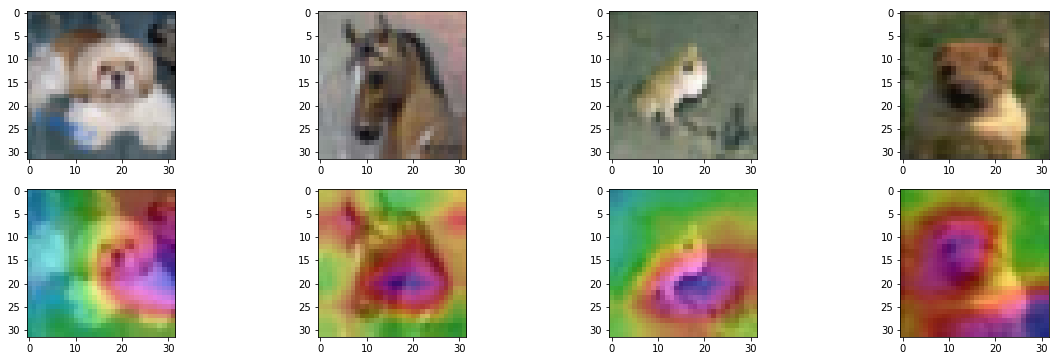

In [0]:
idx = [39,210,304,437]
fig, ax = plt.subplots(2, 4, figsize = (20,6))

for i, val in enumerate(idx): 
  print (i, ": Image class Id",val)
  img = test_features[val]*255
  heatmap = getHeatMapFromLayer('conv2d_104',img)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HSV)
  superimposed_img = cv2.addWeighted(img.astype(float), 0.6, heatmap.astype(float), 0.4, 0)
  ax[0, i].imshow(img/255)
  ax[1, i].imshow(superimposed_img/255)
  
plt.show()